In [1]:
"""
Synthetic → Real augmentation pipeline for YOLO datasets

This script:
- takes synthetic images + YOLO labels
- applies heavy, realistic degradation
- saves augmented images + unchanged labels

Intended usage:
- preprocess synthetic dataset BEFORE training
- or generate an augmented copy

Author intent:
Make synthetic data ugly enough that YOLO stops cheating.
"""

'\nSynthetic → Real augmentation pipeline for YOLO datasets\n\nThis script:\n- takes synthetic images + YOLO labels\n- applies heavy, realistic degradation\n- saves augmented images + unchanged labels\n\nIntended usage:\n- preprocess synthetic dataset BEFORE training\n- or generate an augmented copy\n\nAuthor intent:\nMake synthetic data ugly enough that YOLO stops cheating.\n'

In [2]:
import cv2
import numpy as np
from pathlib import Path
import random
import shutil

In [8]:
frag = Path("../crops/v2/2.png")
bg1 = Path("../../mapillary_downloader/data/samples/bangalore/images/115961287612785.jpg")
bg2 = Path("../../mapillary_downloader/data/samples/bangalore/images/124028993051185.jpg")
frag.exists(), bg1.exists(), bg2.exists()

(True, True, True)

In [9]:
# =========================
# CONFIGURATION
# =========================

INPUT_IMAGES = Path("data/synth/images/train")
INPUT_LABELS = Path("data/synth/labels/train")

OUTPUT_IMAGES = Path("data/aug/images/train")
OUTPUT_LABELS = Path("data/aug/labels/train")

IMAGE_EXT = ".jpg"  # change if needed

# Probability of each corruption being applied
AUG_PROBS = {
    "brightness": 0.9,
    "color_temp": 0.8,
    "blur": 0.6,
    "noise": 0.8,
    "jpeg": 0.7,
    "occlusion": 0.5,
    "perspective": 0.3,
}

random.seed(42)
np.random.seed(42)

In [ ]:
# =========================
# UTILITY FUNCTIONS
# =========================

def clamp(img):
    """Ensure pixel values stay valid."""
    return np.clip(img, 0, 255).astype(np.uint8)

In [13]:
import matplotlib.pyplot as plt
from ultralytics import YOLO

model = YOLO("best.pt")

def _predict_image(model, image_path, conf_threshold=0.1):
    # Run inference
    results = model(image_path, conf=conf_threshold, verbose=False)[0]

    # Visualize
    img = cv2.imread(str(image_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for box in results.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0].cpu().numpy())
        cls = int(box.cls[0])
        color = plt.cm.tab10(cls % 10)[:3]
        color = tuple(int(c * 255) for c in color)
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 5)
    return img

In [ ]:
_predict_image(model, bg1)

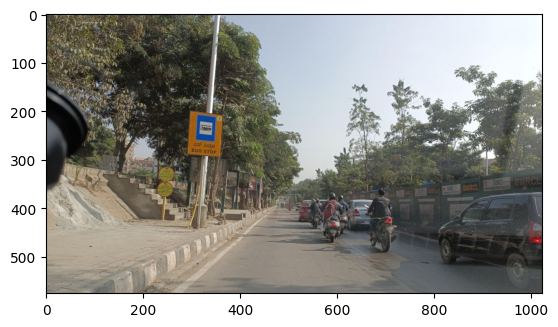

In [10]:
import matplotlib.pyplot as plt

plt.imshow(plt.imread(bg1))

In [ ]:
# =========================
# PHOTOMETRIC AUGMENTATIONS
# =========================

def random_brightness_contrast(img):
    """
    Simulates exposure + gain changes.
    Real cameras almost never have perfect exposure.
    """
    alpha = random.uniform(0.6, 1.4)  # contrast
    beta = random.uniform(-40, 40)    # brightness
    return clamp(alpha * img + beta)


def random_color_temperature(img):
    """
    Simulates different lighting temperatures
    (warm indoor, cold daylight, mixed lighting).
    """
    img = img.astype(np.float32)

    # Random RGB gains
    r_gain = random.uniform(0.8, 1.2)
    g_gain = random.uniform(0.9, 1.1)
    b_gain = random.uniform(0.8, 1.2)

    img[..., 0] *= b_gain
    img[..., 1] *= g_gain
    img[..., 2] *= r_gain

    return clamp(img)

In [ ]:
# =========================
# BLUR & NOISE
# =========================

def random_blur(img):
    """
    Mix of motion blur and defocus blur.
    Synthetic data is always too sharp.
    """
    choice = random.choice(["motion", "gaussian"])

    if choice == "motion":
        k = random.choice([3, 5, 7])
        kernel = np.zeros((k, k))
        kernel[k // 2, :] = 1.0 / k
        return cv2.filter2D(img, -1, kernel)

    else:
        k = random.choice([3, 5, 7])
        return cv2.GaussianBlur(img, (k, k), 0)


def random_noise(img):
    """
    Simulates sensor + ISO noise.
    """
    noise = np.random.normal(0, random.uniform(5, 25), img.shape)
    return clamp(img + noise)

In [ ]:
# =========================
# COMPRESSION ARTIFACTS
# =========================

def random_jpeg_compression(img):
    """
    Forces JPEG artifacts like in real pipelines,
    messaging apps, CCTV, etc.
    """
    quality = random.randint(20, 70)
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
    _, enc = cv2.imencode(".jpg", img, encode_param)
    return cv2.imdecode(enc, cv2.IMREAD_COLOR)

In [ ]:
# =========================
# GEOMETRIC AUGMENTATIONS
# =========================

def random_occlusion(img):
    """
    Simulates partial occlusion (people, poles, clutter).
    Does NOT modify labels – YOLO can learn robustness.
    """
    h, w, _ = img.shape

    for _ in range(random.randint(1, 3)):
        x1 = random.randint(0, w - 1)
        y1 = random.randint(0, h - 1)
        x2 = min(w, x1 + random.randint(20, 100))
        y2 = min(h, y1 + random.randint(20, 100))

        color = random.randint(0, 255)
        img[y1:y2, x1:x2] = color

    return img


def random_perspective(img):
    """
    Simulates imperfect camera alignment.
    Synthetic cameras are always too perfect.
    """
    h, w = img.shape[:2]

    margin = int(0.05 * min(h, w))
    pts1 = np.float32([[0,0],[w,0],[w,h],[0,h]])
    pts2 = np.float32([
        [random.randint(0, margin), random.randint(0, margin)],
        [w - random.randint(0, margin), random.randint(0, margin)],
        [w - random.randint(0, margin), h - random.randint(0, margin)],
        [random.randint(0, margin), h - random.randint(0, margin)]
    ])

    M = cv2.getPerspectiveTransform(pts1, pts2)
    return cv2.warpPerspective(img, M, (w, h))

In [ ]:
# =========================
# MAIN AUGMENTATION PIPELINE
# =========================

def augment_image(img):
    """
    Applies a randomized subset of degradations.
    Order matters: geometry → photometric → compression.
    """

    if random.random() < AUG_PROBS["perspective"]:
        img = random_perspective(img)

    if random.random() < AUG_PROBS["brightness"]:
        img = random_brightness_contrast(img)

    if random.random() < AUG_PROBS["color_temp"]:
        img = random_color_temperature(img)

    if random.random() < AUG_PROBS["blur"]:
        img = random_blur(img)

    if random.random() < AUG_PROBS["noise"]:
        img = random_noise(img)

    if random.random() < AUG_PROBS["occlusion"]:
        img = random_occlusion(img)

    if random.random() < AUG_PROBS["jpeg"]:
        img = random_jpeg_compression(img)

    return img

In [ ]:
# =========================
# DATASET DRIVER
# =========================

def run():
    OUTPUT_IMAGES.mkdir(parents=True, exist_ok=True)
    OUTPUT_LABELS.mkdir(parents=True, exist_ok=True)

    images = sorted(INPUT_IMAGES.glob(f"*{IMAGE_EXT}"))

    for img_path in images:
        label_path = INPUT_LABELS / (img_path.stem + ".txt")

        if not label_path.exists():
            continue

        img = cv2.imread(str(img_path))
        aug = augment_image(img)

        # Save image
        out_img = OUTPUT_IMAGES / img_path.name
        cv2.imwrite(str(out_img), aug)

        # Labels are copied verbatim
        shutil.copy(label_path, OUTPUT_LABELS / label_path.name)

    print(f"Augmented {len(images)} images.")

In [ ]:
if __name__ == "__main__":
    run()